# Part1

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [2]:
## Importing Basic Packages
import matplotlib.pyplot as plt
import numpy as np

# Import NLP Packages
import re
import nltk
from wordcloud import WordCloud

# NLTK Stop words
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [3]:
spark = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.memory','16g').config('spark.driver.maxResultSize','0').config('spark.sql.autoBroadcastJoinThreshold','-1').config('spark.sql.broadcastTimeout','1200').config('spark.default.parallelism','8').appName("part123").getOrCreate()

# Bussiness

In [4]:
path = 'yelp_academic_dataset_business.json'
business = spark.read.json(path)
business.count()

160585

In [5]:
business_col = ['business_id','name','city','state','stars','review_count','categories','latitude','longitude','is_open', 'postal_code']
business = business.select(business_col)
#business = business.withColumn('category', split(business['categories'],',')).withColumn('category',explode('category')).withColumn('category', trim('category'))


In [6]:
tmp = business.withColumn('category', explode(split(business['categories'],','))).withColumn('category', trim('category'))
tmp.groupBy('category').count().orderBy('count',ascending=False).show()
#selected_category = ['Restaurants','Food','Coffee & Tea','Sandwiches','Breakfast & Brunch']
regex_expr = r'\b(Restaurants|Food|Coffee|Tea|Sandwiches|Breakfast|Brunch)\b'
business = business.filter(business['categories'].rlike(regex_expr))


+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|50763|
|                Food|29469|
|            Shopping|26205|
|       Beauty & Spas|16574|
|       Home Services|16465|
|    Health & Medical|15102|
|      Local Services|12192|
|           Nightlife|11990|
|                Bars|10741|
|          Automotive|10119|
|Event Planning & ...| 9644|
|         Active Life| 9231|
|        Coffee & Tea| 7725|
|          Sandwiches| 7272|
|             Fashion| 6599|
|American (Traditi...| 6541|
|         Hair Salons| 5900|
|               Pizza| 5756|
|     Hotels & Travel| 5703|
|  Breakfast & Brunch| 5505|
+--------------------+-----+
only showing top 20 rows



In [7]:
business.count()

64092

In [7]:
business.groupBy('city').count().orderBy('count',ascending = False).show()
selected_city = ['Portland']
business = business.filter(col('city').isin(selected_city))


+---------------+-----+
|           city|count|
+---------------+-----+
|       Portland| 7212|
|      Vancouver| 6495|
|         Austin| 6373|
|        Atlanta| 5092|
|        Orlando| 4592|
|         Boston| 3536|
|       Columbus| 3164|
|       Richmond| 1127|
|      Cambridge|  957|
|        Burnaby|  919|
|        Boulder|  882|
|      Kissimmee|  846|
|      Beaverton|  735|
|        Decatur|  627|
|     Somerville|  510|
|North Vancouver|  500|
|    Winter Park|  495|
|         Quincy|  414|
|      Coquitlam|  383|
|         Surrey|  344|
+---------------+-----+
only showing top 20 rows



In [8]:
business = business[business['is_open']==1]
business.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in business.columns]).show()

+-----------+----+----+-----+-----+------------+----------+--------+---------+-------+-----------+
|business_id|name|city|state|stars|review_count|categories|latitude|longitude|is_open|postal_code|
+-----------+----+----+-----+-----+------------+----------+--------+---------+-------+-----------+
|          0|   0|   0|    0|    0|           0|         0|       0|        0|      0|          0|
+-----------+----+----+-----+-----+------------+----------+--------+---------+-------+-----------+



In [10]:
business.count()

4127

# Review

In [9]:
path = 'yelp_academic_dataset_review.json'
review = spark.read.json(path)

In [10]:
review.count()

8635403

In [10]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [11]:
review.show(10)
review = review.withColumn('year', substring('date',1,4).astype('int'))
review = review.withColumn('month', substring('date',6,2).astype('int'))
review = review.withColumn('day', substring('date',9,2).astype('int'))

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|buF9druCkbuXLX526...|   1|2014-10-11 03:34:02|    1|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...|     3|ak0TdVmGKo4pwqdJS...|
|RA4V8pr014UyUbDvI...|   0|2015-07-03 20:38:25|    0|8bFej1QE5LXp4O05q...|  4.0|This store is pre...|     1|YoVfDbnISlW0f7abN...|
|_sS2LBIGNT5NQb6PD...|   0|2013-05-28 20:38:06|    0|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...|     0|eC5evKn1TWDyHCyQA...|
|0AzLzHfOJgL7ROwhd...|   1|2010-01-08 02:29:15|    1|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...|     1|SFQ1jcnGguO0LYWnb...|
|8zehGz9jnxPqXtOc7...|   0|2011-07-28 18:05:01|    0|sjm_uUcQVxab_EeLC...|  4.0|The food i

In [12]:
review_col = ['review_id','business_id','user_id','year','month','day','stars','useful','funny','cool','text']
review = review.select(review_col)

In [13]:
review.show(10)

+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|           review_id|         business_id|             user_id|year|month|day|stars|useful|funny|cool|                text|
+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|lWC-xP3rd6obsecCY...|buF9druCkbuXLX526...|ak0TdVmGKo4pwqdJS...|2014|   10| 11|  4.0|     3|    1|   1|Apparently Prides...|
|8bFej1QE5LXp4O05q...|RA4V8pr014UyUbDvI...|YoVfDbnISlW0f7abN...|2015|    7|  3|  4.0|     1|    0|   0|This store is pre...|
|NDhkzczKjLshODbqD...|_sS2LBIGNT5NQb6PD...|eC5evKn1TWDyHCyQA...|2013|    5| 28|  5.0|     0|    0|   0|I called WVM on t...|
|T5fAqjjFooT4V0OeZ...|0AzLzHfOJgL7ROwhd...|SFQ1jcnGguO0LYWnb...|2010|    1|  8|  2.0|     1|    1|   1|I've stayed at ma...|
|sjm_uUcQVxab_EeLC...|8zehGz9jnxPqXtOc7...|0kA0PAJ8QFMeveQWH...|2011|    7| 28|  4.0|     0|    0|   0|The food is alway...|


In [9]:
review.count()

8635403

# filter review that in bussiness dataset

In [13]:
business_id_set = set()
for i in list(business.select('business_id').collect()):
    business_id_set.add(i[0])

In [19]:
review.count()

8635403

In [14]:
review = review.filter(review['business_id'].isin(business_id_set))

In [18]:
review.count()

605597

# remove reviews before 2010

In [17]:
review.groupBy('year').count().orderBy('year').show()

+----+-----+
|year|count|
+----+-----+
|2004|    1|
|2005|   72|
|2006|  607|
|2007| 3369|
|2008| 8183|
|2009|13023|
|2010|20037|
|2011|27092|
|2012|30442|
|2013|38252|
|2014|52003|
|2015|66122|
|2016|69181|
|2017|74100|
|2018|80903|
|2019|76977|
|2020|42588|
|2021| 2645|
+----+-----+



In [15]:
review = review.filter(review.year>2010)

In [17]:
review.count()

560305

## Part 2 :Sentiment Analysis

In [16]:
review.select(['text']).show(5)

+--------------------+
|                text|
+--------------------+
|The ramen here is...|
|"Even the mad Cap...|
|It's crazy how es...|
|5 stars for the l...|
|That was very gra...|
+--------------------+
only showing top 5 rows



### Negative Reviews Forsight

In [18]:
neg_reviews = review.filter(review.stars <= 2.5)  # reviews with star <= 2.5
# print(neg_reviews.count(), len(neg_reviews.columns))

In [19]:
neg_reviews.show(5)

+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|           review_id|         business_id|             user_id|year|month|day|stars|useful|funny|cool|                text|
+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|EO5rALvJMkK8QEvUN...|9P-lp3AWDXGayDqJz...|u2xPfv6_wcKt-lW-C...|2018|    2| 11|  2.0|     0|    0|   0|The ramen here is...|
|ggecU8oSt68aGEuiE...|7EbGTD7ZF30vEFBiH...|uQSBQI8hKuNRxyxhP...|2013|   10|  3|  2.0|     2|    0|   0|I don't remember ...|
|UaxxixKaWiAL7_Oc_...|szCpLKuocAQnErkNi...|MrA1ib9jw_tw-uDzn...|2013|    8|  3|  2.0|     1|    0|   0|The renovation is...|
|Q9Jh7uDqUYpM8aR3F...|ftc6tzrCBJVbuIi_y...|UNgMSeVC-Jk2q6ZhI...|2015|   10| 17|  1.0|     3|    0|   0|This pharmacy has...|
|Q9qveSMALhyPZn7st...|Wv1A_nvyUuMEThZFu...|tI8Lve0J6JPklfUcJ...|2016|    6| 22|  2.0|     0|    0|   0|I actually love W...|


In [24]:
from pyspark.ml.feature import CountVectorizer, StopWordsRemover, RegexTokenizer

neg_reviews_text = neg_reviews.select(['text'])

tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(neg_reviews_text)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors')
model = cv.fit(filter_data)

counts = model.transform(filter_data).select(['filtered','vectors'])

neg_words_top10 = counts.select('vectors', explode("filtered").alias("word")).groupBy("word").count()
neg_words_top10 = neg_words_top10.sort("count", ascending=False)
neg_words_top10.show(10) # list

+-------+-----+
|   word|count|
+-------+-----+
|   food|70991|
|  place|43913|
|   like|42428|
|service|39138|
|   good|38361|
|    one|36118|
|    get|33493|
|   time|33280|
|   back|32405|
|     us|31669|
+-------+-----+
only showing top 10 rows



In [93]:
# Remove non-informative words
tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(neg_reviews_text)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors',minDF=2.0, vocabSize=1000)
model = cv.fit(filter_data)

counts = model.transform(filter_data).select(['filtered','vectors'])

non_informative_words = ['food', 'place', 'like', 'service','good','one','get','time','back','us']

neg_words_top150 = counts.select('vectors', explode("filtered").alias("word")).where(col("word").isin(non_informative_words)==False).groupBy("word").count()
neg_words_top150 = neg_words_top150.sort("count", ascending=False)
neg_words_top150 = neg_words_top150.select(['word']).take(150) # list

In [101]:
neg_words_top150_list = []
for nwt150 in neg_words_top150:
    if nwt150['word'].isnumeric():
        continue
    neg_words_top150_list.append(nwt150['word'])

In [102]:
print(neg_words_top150_list)

['order', 'go', 'ordered', 'even', 'got', 'really', 'didn', 'never', 'said', 'minutes', 'came', 've', 'm', 'people', 'asked', 'restaurant', 'great', 'went', 'table', 'bad', 'two', 'better', 'first', 'also', 'told', 'way', 'chicken', 'know', 'much', 'going', 'wait', 'experience', 'bar', 'come', 'make', 'portland', 'staff', 'want', 'well', 'took', 'customer', 'menu', 'made', 'eat', 'another', 'wasn', 'take', 'ever', 'give', 'pizza', 'server', 're', 'say', 'still', 'nice', 'pretty', 'times', 'left', 'long', 'try', 'think', 'last', 'rude', 'sauce', 'hour', 'around', 'something', 'night', 'wanted', 'drinks', 'little', 'drink', 'right', 'day', 'nothing', 'coffee', 'see', 'sure', 'd', 'meal', 'taste', 'maybe', 'many', 'waiting', 'since', 'waitress', 'flavor', 'small', 'll', 'ok', 'salad', 'disappointed', 'cheese', 'tasted', 'won', 'away', 'waited', 'worst', 'customers', 'money', 'meat', 'thing', 'though', 'ask', 'location', 'next', 'line', 'new', 'tried', 'cold', 'half', 'quality', 'put', 'be

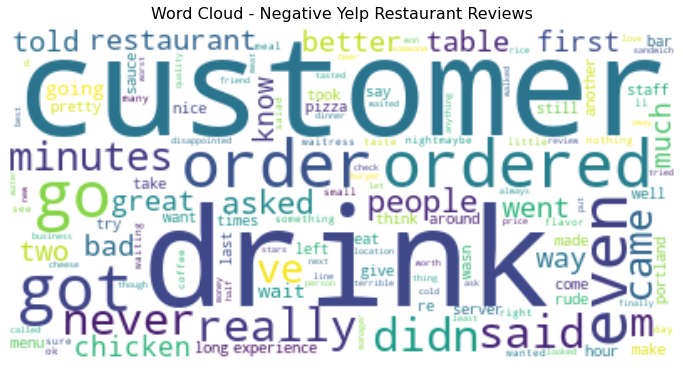

In [104]:
wordcloud_low = WordCloud(background_color="white").generate(' '.join(neg_words_top150_list))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud - Negative Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off")

### Positive Reviews Forsight

In [105]:
pos_reviews = review.filter(review.stars >= 4.5)  # reviews with star >= 4.5
print(pos_reviews.count(), len(pos_reviews.columns))

277935 11


In [106]:
pos_reviews.show(5)

+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|           review_id|         business_id|             user_id|year|month|day|stars|useful|funny|cool|                text|
+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+
|oL2y3mXe_qab349DP...|0nMbLN0B5I-2tNnQL...|4cDqW9sWnZ57tsIEi...|2017|   12|  2|  5.0|     4|    4|   4|"Even the mad Cap...|
|-biqGbwMjaXOWxWvi...|0WqROvvlHjvpeHIP0...|uQSBQI8hKuNRxyxhP...|2015|    9| 23|  5.0|     0|    0|   0|That was very gra...|
|T6EtnGwJqhFgZXyIB...|X9sz3xeaLujW9PhsS...|EdR5dIPOK9fR_IFGc...|2017|   12|  2|  5.0|     0|    0|   0|Realize this is a...|
|Gu2SqkTutHUI5JyfA...|JgjMHbZ4A407ZOmvE...|KwHyQ0NCMMHPydDOm...|2016|    8|  3|  5.0|     0|    0|   0|We've been big fa...|
|Zul1x6eu4VPaqwVOd...|lyhNDfX8UatlRO5H3...|-zqGTvnQt9IFgTsUv...|2015|    9| 23|  5.0|     4|    2|   2|As many people be...|


In [107]:
pos_reviews_text = pos_reviews.select(['text'])

tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(pos_reviews_text)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors')
model = cv.fit(filter_data)

counts = model.transform(filter_data).select(['filtered','vectors'])

pos_words_top10 = counts.select('vectors', explode("filtered").alias("word")).groupBy("word").count()
pos_words_top10 = pos_words_top10.sort("count", ascending=False)
pos_words_top10.show(10) # list

+---------+------+
|     word| count|
+---------+------+
|     food|151079|
|    great|138583|
|    place|134844|
|     good|113510|
| portland| 75232|
|delicious| 73429|
|  service| 72133|
|     best| 71116|
|      one| 67410|
|     like| 64261|
+---------+------+
only showing top 10 rows



In [108]:
# Remove non-informative words
tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(pos_reviews_text)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors',minDF=2.0, vocabSize=1000)
model = cv.fit(filter_data)

counts = model.transform(filter_data).select(['filtered','vectors'])

non_informative_words = ['food', 'place', 'like', 'service','portland','one']

pos_words_top150 = counts.select('vectors', explode("filtered").alias("word")).where(col("word").isin(non_informative_words)==False).groupBy("word").count()
pos_words_top150 = pos_words_top150.sort("count", ascending=False)
pos_words_top150 = pos_words_top150.select(['word']).take(150) # list

In [109]:
pos_words_top150_list = []
for pwt150 in pos_words_top150:
    if pwt150['word'].isnumeric():
        continue
    pos_words_top150_list.append(pwt150['word'])

In [110]:
print(pos_words_top150_list)

['great', 'good', 'delicious', 'best', 'back', 'love', 'time', 'go', 'amazing', 've', 'get', 'really', 'also', 'friendly', 'well', 'always', 'staff', 'definitely', 'try', 'chicken', 'm', 'got', 'nice', 'coffee', 'menu', 'favorite', 'wait', 'even', 'fresh', 'us', 'ordered', 'restaurant', 'made', 'ever', 'everything', 'little', 'order', 'come', 'super', 'recommend', 'perfect', 're', 'first', 'make', 'every', 'bar', 'people', 'awesome', 'came', 'eat', 'happy', 'pizza', 'much', 'excellent', 'day', 'cheese', 'experience', 'right', 'sauce', 'spot', 'never', 'went', 'worth', 'salad', 'new', 'beer', 'want', 'tried', 'sweet', 'drinks', 'flavor', 'cream', 'way', 'know', 'two', 'll', 'meal', 'night', 'breakfast', 'atmosphere', 'loved', 'next', 'many', 'tasty', 'fried', 'dinner', 'flavors', 'sure', 'around', 'going', 'pretty', 'say', 'better', 'highly', 'take', 'find', 'small', 'didn', 'area', 'wonderful', 'ice', 'lunch', 'fantastic', 'think', 'visit', 'sandwich', 'long', 'quality', 'town', 'pork'

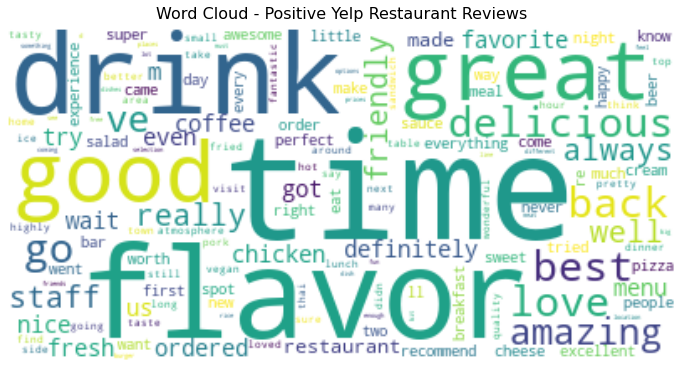

In [114]:
wordcloud_low = WordCloud(background_color="white").generate(' '.join(pos_words_top150_list))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud - Positive Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

### Rich Features for Review

In [17]:
from pyspark.sql.types import *
from textblob import Word

# review = review.withColumn('char_count', length(review['text']))

# def cal_word_count(value):
#     return len(value.split(" "))

# udfcal_word_count = udf(cal_word_count, IntegerType())
# review = review.withColumn("word_count", lit(udfcal_word_count("text")))

# def cal_avg_word_len(value):
#     words = value.split()
#     word_sum = 0
#     for word in words:
#         word_sum += len(word)
#     result = word_sum / len(words)
#     return result

# udfcal_avg_word_len = udf(cal_avg_word_len, DoubleType())
# review = review.withColumn("avg_word_len", lit(udfcal_avg_word_len("text")))

# def cal_stopword_count(value):
#     words = value.split(" ")
#     spcount = 0
#     for word in words:
#         if word in stop_words:
#             spcount += 1
#     return spcount

# udfcal_stopword_count = udf(cal_stopword_count, IntegerType())
# review = review.withColumn("stopword_count", lit(udfcal_stopword_count("text")))

# review.show(3)


In [18]:
def get_cleaned_text(value):
    words = re.split("(?:[^a-zA-Z']+)", value.lower())
    result = " "
    result = result.join(Word(w.lower()).lemmatize() for w in words if w.lower() not in stop_words)
    return result

udfget_cleaned_text = udf(get_cleaned_text, StringType())
review = review.withColumn("cleaned_text", lit(udfget_cleaned_text("text")))

# review.show(3, truncate=False)

In [19]:
review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- stars: double (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)



### Text Classification

In [20]:
# Add column 'polarity' and 'subjectivity'
from textblob import TextBlob

def cal_polarity(value):
    return TextBlob(value).sentiment[0]

udfcal_polarity = udf(cal_polarity, DoubleType())
review = review.withColumn("polarity", lit(udfcal_polarity("cleaned_text")))

def cal_subjectivity(value):
    return TextBlob(value).sentiment[1]

udfcal_subjectivity = udf(cal_subjectivity, DoubleType())
review = review.withColumn("subjectivity", lit(udfcal_subjectivity("cleaned_text")))

# review.show(3, truncate=False)

In [21]:
# Calculate Vader Sentiment Analysis Scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# test = analyzer.polarity_scores("The ramen here is less than great. It came out luke warm and oily. The service we received was NOT good. I will not be returning.")

# print(test)

def cal_compound(value):
    return analyzer.polarity_scores(value)['compound']

udfcal_compound = udf(cal_compound, DoubleType())
review = review.withColumn("compound", lit(udfcal_compound("text")))

### Vader Sentiment

In [22]:
# def cal_neg(value):
#     return analyzer.polarity_scores(value)['neg']

# udfcal_neg = udf(cal_neg, DoubleType())
# review = review.withColumn("neg", lit(udfcal_neg("text")))

# def cal_neu(value):
#     return analyzer.polarity_scores(value)['neu']

# udfcal_neu = udf(cal_neu, DoubleType())
# review = review.withColumn("neu", lit(udfcal_neu("text")))

# def cal_pos(value):
#     return analyzer.polarity_scores(value)['pos']

# udfcal_pos = udf(cal_pos, DoubleType())
# review = review.withColumn("pos", lit(udfcal_pos("text")))

review.show(2, truncate=False)

+----------------------+----------------------+----------------------+----+-----+---+-----+------+-----+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- stars: double (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- compound: double (nullable = true)



In [25]:
print(review.count(), len(review.columns))

560305 15


## Part 3: Topic Modelling

In [23]:
dropped_review = review.filter(review.polarity == 0.0)
dropped_review = dropped_review.filter(dropped_review.subjectivity == 0.0)
dropped_review = dropped_review.filter(dropped_review.compound == 0.0)

In [24]:
dropped_id_set = set()
for i in list(dropped_review.select('review_id').collect()):
    dropped_id_set.add(i[0])

In [48]:
print(len(dropped_id_set))

971


In [25]:
combined_review = review.filter(review['review_id'].isin(dropped_id_set) == False)
combined_review = combined_review.dropna()

In [51]:
print(combined_review.count()) # 559334 + 971 = 560305

559334


In [28]:
combined_review.show(3)

+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+--------------------+-------------------+------------------+--------+
|           review_id|         business_id|             user_id|year|month|day|stars|useful|funny|cool|                text|        cleaned_text|           polarity|      subjectivity|compound|
+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+--------------------+-------------------+------------------+--------+
|EO5rALvJMkK8QEvUN...|9P-lp3AWDXGayDqJz...|u2xPfv6_wcKt-lW-C...|2018|    2| 11|  2.0|     0|    0|   0|The ramen here is...|ramen le great ca...|                0.7|             0.675|  0.5132|
|oL2y3mXe_qab349DP...|0nMbLN0B5I-2tNnQL...|4cDqW9sWnZ57tsIEi...|2017|   12|  2|  5.0|     4|    4|   4|"Even the mad Cap...| mad captain ahab...|0.17575757575757578|0.5585081585081585|  0.9812|
|OH9E5SaGBQsPX3Ikt...|Un6u2cEC

In [34]:
dropped_review = dropped_review.dropna()
dropped_review = dropped_review.select(['text'])

In [38]:
dropped_review.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [29]:
print(dropped_review.count())

971


In [37]:
combined_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- stars: double (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- compound: double (nullable = true)



In [ ]:
# Topic Modeling
from pyspark.sql import SQLContext, Row
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.feature import CountVectorizer, StopWordsRemover, RegexTokenizer

tp_reviews = combined_review.select(['text'])

tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(tp_reviews)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors',minDF=2.0, vocabSize=1000)
model = cv.fit(filter_data)


In [ ]:
result = model.transform(filter_data)

In [34]:
result = result.select("*").withColumn("id", monotonically_increasing_id())
result.show(3)

+--------------------+--------------------+--------------------+--------------------+---+
|                text|               words|            filtered|             vectors| id|
+--------------------+--------------------+--------------------+--------------------+---+
|The ramen here is...|[the, ramen, here...|[ramen, less, gre...|(1000,[1,3,5,37,2...|  0|
|"Even the mad Cap...|[even, the, mad, ...|[even, mad, capta...|(1000,[3,4,8,11,1...|  1|
|It's crazy how es...|[it, s, crazy, ho...|[crazy, establish...|(1000,[0,4,11,15,...|  2|
+--------------------+--------------------+--------------------+--------------------+---+
only showing top 3 rows



In [35]:
result = result.repartition(100)

In [39]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="vectors", outputCol="features")
idfModel = idf.fit(result)
result_tfidf = idfModel.transform(result)

In [76]:
corpus = result.select(['id','vectors']).rdd.map(lambda x: [x[0],Vectors.fromML(x[1])]).cache()

In [ ]:
ldaModel = LDA.train(corpus, k=7,maxIterations=50,optimizer='online')
topics = ldaModel.topicsMatrix()
vocabArray = model.vocabulary

In [52]:
wordNumbers = 10  # number of words per topic
topicIndices = spark.sparkContext.parallelize(ldaModel.describeTopics(maxTermsPerTopic = wordNumbers))

In [53]:
def topic_render(topic):  # specify vector id of words to actual words
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()

In [54]:
for topic in range(len(topics_final)):
    print ("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print (term)
    print ('\n')

Topic0:
cream
ice
portland
like
place
good
one
flavors
donuts
food


Topic1:
food
us
ordered
time
service
came
table
order
back
one


Topic2:
coffee
good
breakfast
place
tea
delicious
like
also
portland
great


Topic3:
like
get
one
place
time
go
order
back
service
good


Topic4:
food
good
great
chicken
place
delicious
service
back
definitely
rice


Topic5:
good
pizza
like
sauce
place
cheese
food
burger
chicken
fries


Topic6:
great
food
place
good
service
love
always
friendly
staff
ve




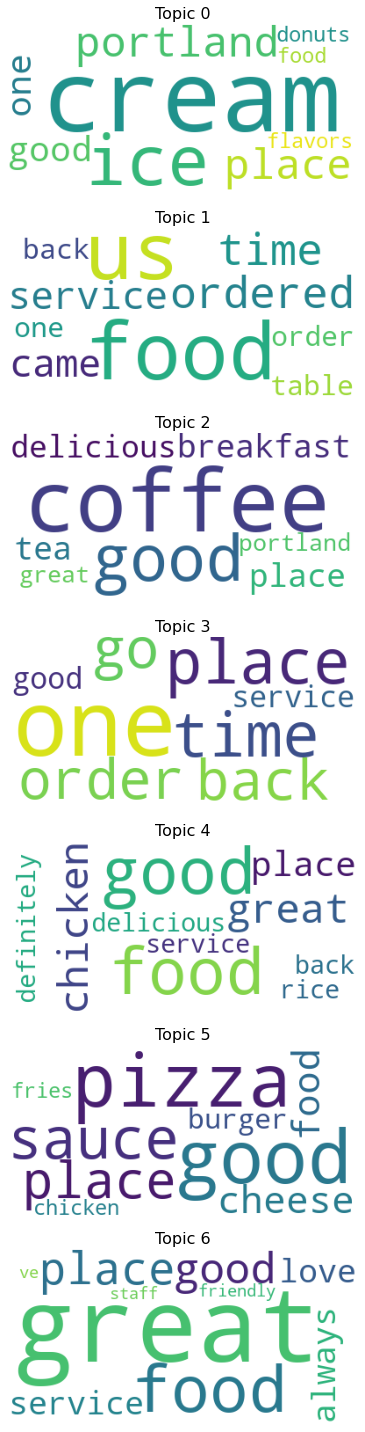

In [67]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(7, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = topics_final[i]
    wordcloud_low = WordCloud(background_color="white").generate(' '.join(topic_words))
    plt.gca().imshow(wordcloud_low)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

In [99]:
from pyspark.ml.clustering import LDA

dataset = result.select(['text','vectors'])

mllda = LDA(featuresCol="vectors",k=7, maxIter=20)
mlmodel = mllda.fit(dataset)

In [100]:
# Describe topics.
topics = mlmodel.describeTopics()
topics.show(truncate=False)

+-----+-------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                          |termWeights                                                                                                                                                                                                                 |
+-----+-------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[2, 0, 40, 4, 20, 1, 8, 7, 11, 9]    |[0.017182451344600353, 0.015333325804015006, 0.011275177483567846, 0.011267584039603701, 0.010455550677618263, 0.010116128673724351, 0.009837395126838525,

In [113]:
from operator import itemgetter 
key_topics = [[] for _ in range(7)]

for i in topics['topic','termIndices'].collect():
    key_topics[i['topic']] = list(itemgetter(*i['termIndices'])(model.vocabulary))

print(key_topics)

[['place', 'food', 'bar', 'like', 'order', 'good', 'time', 'get', 'go', 'back'], ['good', 'cream', 'place', 've', 'get', 'ice', 'one', 'like', 'portland', 'best'], ['place', 'coffee', 'like', 'great', 'good', 'love', 'one', 'portland', 'time', 'get'], ['pizza', 'good', 'food', 'like', 'service', 'place', 'sushi', 'great', 'one', 'get'], ['food', 'us', 'good', 'service', 'time', 'back', 'ordered', 'came', 'great', 'really'], ['good', 'great', 'place', 'food', 'chicken', 'delicious', 'cheese', 'sandwich', 'amazing', 'also'], ['food', 'great', 'place', 'good', 'service', 'chicken', 'delicious', 'thai', 'friendly', 'best']]


In [102]:
# Shows the result
transformed = mlmodel.transform(dataset)
transformed.show(3,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                       

In [166]:
transformed = mlmodel.transform(dataset)

In [170]:
transformed.printSchema()

root
 |-- text: string (nullable = true)
 |-- vectors: vector (nullable = true)
 |-- topicDistribution: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [168]:
from pyspark.ml.functions import vector_to_array
transformed = transformed.withColumn("topicDistribution", vector_to_array("topicDistribution"))

In [171]:
transformed = transformed.drop('vectors')

In [172]:
transformed = transformed.drop('topicDistribution')

In [169]:
def tran_keywords(value):
    max_index = int(np.argmax(value))
    return key_topics[max_index]

udftran_keywords = udf(tran_keywords, ArrayType(StringType()))
transformed = transformed.withColumn("Keywords", lit(udftran_keywords("topicDistribution")))


In [174]:
transformed.show(2,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                                           |Keywords                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [215]:
final_review = combined_review.join(transformed, combined_review.text == transformed.text, 'inner')

In [216]:
final_review = final_review.drop('text')
final_review = final_review.drop('year')
final_review = final_review.drop('month')
final_review = final_review.drop('day')
final_review = final_review.drop('useful')
final_review = final_review.drop('funny')
final_review = final_review.drop('cool')

In [217]:
final_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- compound: double (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



# User

In [232]:
path = 'yelp_academic_dataset_user.json'
user = spark.read.json(path)

In [233]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [5]:
user_col = ['user_id','name','review_count','yelping_since','friends','useful','funny','cool','fans','average_stars']
user = user.select(user_col)

In [6]:
user.show(10)

+--------------------+----------+------------+-------------------+--------------------+------+-----+-----+----+-------------+
|             user_id|      name|review_count|      yelping_since|             friends|useful|funny| cool|fans|average_stars|
+--------------------+----------+------------+-------------------+--------------------+------+-----+-----+----+-------------+
|q_QQ5kBBwlCcbL1s4...|      Jane|        1220|2005-03-14 20:26:35|xBDpTUbai0DXrvxCe...| 15038|10030|11291|1357|         3.85|
|dIIKEfOgo0KqUfGQv...|      Gabi|        2136|2007-08-10 19:01:51|XPzYf9_mwG2eXYP2B...| 21272|10289|18046|1025|         4.09|
|D6ErcUnFALnCQN4b1...|     Jason|         119|2007-02-07 15:47:53|GfB6sC4NJQvSI2ewb...|   188|  128|  130|  16|         3.76|
|JnPIjvC0cmooNDfsa...|       Kat|         987|2009-02-09 16:14:29|HQZPQhKMwRAyS6BCs...|  7234| 4722| 4035| 420|         3.77|
|37Hc8hr3cw0iHLoPz...| Christine|         495|2008-03-03 04:57:05|-Q88pZUcrfN0BLBDp...|  1577|  727| 1124|  47|       

In [7]:
# get active user
user = user[user.review_count>10]

In [8]:
user.count()

726250

# save to csv

In [29]:
# col = ['business_id','name','city','state','stars','review_count','categories','latitude','longitude','is_open', 'postal_code']
# city = ['Portland']
# category =  ['Restaurants','Food','Coffee & Tea','Sandwiches','Breakfast & Brunch']
# is_open = 1
business_df = business.toPandas()
business_df.to_csv('business.csv',index=False)

In [34]:
# col = ['review_id','business_id','user_id','year','month','day','stars','useful','funny','cool','text']
# only include reviews which "business_id" in "bussiness.json"
review_df = review.toPandas()
review_df.to_csv('review.csv',index=False)

In [9]:
# col = ['user_id','name','review_count','yelping_since','friends','useful','funny','cool','fans','average_stars']
user_df = user.toPandas()
user_df.to_csv('user.csv',index=False)